In [1]:
# imports
%matplotlib inline
%load_ext autoreload
%aimport statefarm
%autoreload 1

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import HTML, display
from collections import OrderedDict
import os
import keras
from statefarm import Statefarm
import theano
import theano.tensor as T
import datetime
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from sklearn.cross_validation import KFold

Using Theano backend.
Using gpu device 0: GeForce GTX TITAN X (CNMeM is enabled with initial size: 10.0% of memory, cuDNN 4007)


In [10]:
# compile loss function:
def log_loss_objective(y_true, y_pred):
    '''Just another log loss'''
    y_pred = T.clip(y_pred, 1.0e-15, 1.0 - 1.0e-15)
    y_pred /= y_pred.sum(axis=-1, keepdims=True)
    cce = T.nnet.categorical_crossentropy(y_pred, y_true)
    return cce

y_true= theano.tensor.matrix()
y_pred = theano.tensor.matrix()
log_loss_objective_compiled = theano.function([y_true,y_pred], log_loss_objective(y_true,y_pred))

In [11]:
# load statefarm data:
use_cache = 1
path_data = "/work/hofinger/code/python/statefarm/input"
path_cache = "/net/store/ni/projects/deeplearning/statefarm/cache"

statefarm = Statefarm(use_cache, path_data, path_cache)

unique_list_train_valid = ['p002', 'p012', 'p014', 'p015', 'p021', 'p022', 'p024',
                 'p026', 'p035', 'p039', 'p041', 'p045', 'p047', 'p049',
                 'p050', 'p051', 'p052', 'p056', 'p061', 'p064', 'p066', 'p072', 'p081', 'p042']
unique_list_test = ['p075', 'p016']

In [12]:
def create_model_v1(img_rows, img_cols, color_type=1, weight_decay=0, 
                    nb_filters1=8, nb_filters2=8, nb_filters3=0, 
                    nb_conv=2, nb_pool=2, nb_dense=128, 
                    dropout1=0, dropout2=0.25, dropout3=0, dropout4=0.5, 
                    lr=None, optimizer='sgd'):
    nb_classes = 10
    model = Sequential()
    
    if nb_filters1:
        model.add(Convolution2D(nb_filters1, nb_conv, nb_conv,
                                border_mode='valid',
                                input_shape=(color_type, img_rows, img_cols),
                                W_regularizer=keras.regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        if dropout1:
            model.add(Dropout(dropout1))
    
    if nb_filters2:
        model.add(Convolution2D(nb_filters2, nb_conv, nb_conv,
                                W_regularizer=keras.regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        if dropout2:
            model.add(Dropout(dropout2))
        
    if nb_filters3:
        model.add(Convolution2D(nb_filters3, nb_conv, nb_conv,
                                W_regularizer=keras.regularizers.l2(weight_decay)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
        if dropout3:
            model.add(Dropout(dropout3))

    model.add(Flatten())
    model.add(Dense(nb_dense))
    model.add(Activation('relu'))
    if dropout4:
        model.add(Dropout(dropout4))
    model.add(Dense(nb_classes))
    model.add(Activation('softmax'))

    if optimizer=="sgd":
        if lr==None:
            lr=0.1
        optim = keras.optimizers.SGD(lr=lr, decay=0, momentum=0, nesterov=False)
    elif optimizer=="rmsprop":
        if lr==None:
            lr=0.01
        optim = keras.optimizers.RMSprop(lr=lr, rho=0.9, epsilon=1e-06)
    else:
        if lr==None:
            lr=1.0
        optim = keras.optimizers.Adadelta(lr=lr, rho=0.95, epsilon=1e-06)

    model.compile(loss=log_loss_objective, optimizer=optim, metrics=["accuracy"])
    return model

In [41]:
# define parameters for grid search:
batch_size = 64
nb_epoch = 100

params_input = {
    'color_type_global': 1, # color type: 1 - grey, 3 - rgb
    'scale_factor': [12, 16], # the factor to reduce resolution
    'interp': 'nearest' # imresize interp: 'nearest','bilinear','bicubic','cubic'
}

params = {
    'nb_filters1': 8, # number of convolutional filters first layer
    'nb_filters2': 10, # number of convolutional filters second layer
    'nb_filters3': 0, # number of convolutional filters third layer
    'nb_pool': 2, # size of pooling area for max pooling
    'nb_conv': 3, # convolution kernel size
    'nb_dense': 60, # number of units in last / fourth layer
    'weight_decay': [0.003, 0.01],
    'dropout1': 0.25,
    'dropout2': 0.25,
    'dropout3': 0,
    'dropout4': [0.4, 0.5, 0.6],
    'optimizer': 'rmsprop',
    'lr': 0.003 # learning rate
}

var_params_group = []
var_params_names = []
var_params_values = []
var_params_length = []
total_nr_runs = 1
for key, val in params.items():
    if isinstance(val, list):
        var_params_group.append('params')
        var_params_names.append(key)
        var_params_values.append(val)
        var_params_length.append(len(val))
        total_nr_runs = total_nr_runs * len(val)
        print('tuning '+str(key)+' with values: '+str(val))
        
for key, val in params_input.items():
    if isinstance(val, list):
        var_params_group.append('params_input')
        var_params_names.append(key)
        var_params_values.append(val)
        var_params_length.append(len(val))
        total_nr_runs = total_nr_runs * len(val)
        print('tuning '+str(key)+' with values: '+str(val))

print('total number of runs: '+str(total_nr_runs))

# start training:
all_log_loss_test = []
all_history = []
all_log_loss_validation = []
all_log_loss_ensemble_medi = []
all_log_loss_ensemble_mean = []
all_checkpoint_filename = []
param_comb = dict()
for k in range(total_nr_runs):
    
    if len(var_params_length)>0:
        multidim_indices = np.unravel_index(k, var_params_length)
        for key, param_name in enumerate(var_params_names):
            index = multidim_indices[key]
            val = var_params_values[key][index]
            print('' + param_name + '[' + str(index) + '] = ' + str(val))

            if var_params_group[key]=='params':
                params[param_name] = val
            elif var_params_group[key]=='params_input':
                params_input[param_name] = val

            if var_params_group[key] not in param_comb.keys():
                param_comb[var_params_group[key]] = dict()
            if param_name not in param_comb[var_params_group[key]].keys():
                param_comb[var_params_group[key]][param_name] = []
            param_comb[var_params_group[key]][param_name].append(val)  
        
    
    # prepare input
    color_type_global = params_input['color_type_global']
    scale_factor = params_input['scale_factor']
    orig_img_rows = 480
    orig_img_cols = 640
    img_rows = int(orig_img_rows/scale_factor)
    img_cols = int(orig_img_cols/scale_factor)

    train_data, train_target, driver_id, unique_drivers = statefarm.read_and_normalize_train_data(img_rows, img_cols, color_type_global)
    X_test, Y_test, test_index = statefarm.copy_selected_drivers(train_data, train_target, driver_id, unique_list_test)
    
    #print('Seed RNG')
    np.random.seed(1234)
    
    random_state = 51
    nfolds = 5
    kf = KFold(len(unique_list_train_valid), n_folds=nfolds, shuffle=True, random_state=random_state)
    num_fold = 0
    
    kfold_log_loss_valid_per_sample = []
    kfold_predictions_test = []
    kfold_history = []
    kfold_log_loss_test = []
    kfold_checkpoint_filename = []
    
    for train_drivers, test_drivers in kf:
        
        unique_list_train = [unique_list_train_valid[i] for i in train_drivers]
        unique_list_valid = [unique_list_train_valid[i] for i in test_drivers]
        
        X_train, Y_train, train_index = statefarm.copy_selected_drivers(train_data, train_target, driver_id, unique_list_train)
        X_valid, Y_valid, valid_index = statefarm.copy_selected_drivers(train_data, train_target, driver_id, unique_list_valid)

        num_fold += 1
        
        print('Start KFold number {} of {}'.format(num_fold, nfolds))

        #print('Start Compiling model')
        model = create_model_v1(img_rows, img_cols, color_type_global, **params)

        init_log_loss_valid = model.evaluate(X_valid, Y_valid, verbose=0)
        #print('Initial: log_loss on validation set: ' + str(init_log_loss_valid[0]))
        init_log_loss_test = model.evaluate(X_test, Y_test, verbose=0)
        #print('Initial: log_loss on test set: ' + str(init_log_loss_test[0]))

        #print('Define training callback to save checkpoints')
        now = datetime.datetime.now()
        checkpoint_filename = 'checkpoint_' + str(now.strftime("%Y-%m-%d-%H-%M-%S")) + '.hdf5'
        kfold_checkpoint_filename.append(checkpoint_filename)
        checkpoint_path = os.path.join('checkpoints', checkpoint_filename)
        checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
        
        early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

        #print('Start training')
        history = model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=0, 
                            validation_data=(X_valid, Y_valid), 
                            callbacks=[checkpoint_callback, early_stopping_cb])
        
        print('early stopping triggered after iteration: ' + str(len(history.history['loss'])))
        kfold_history.append(history)

        epochId_best_validation = np.argmin(history.history["val_loss"])
        print('epoch with best performance on validation set: ' + str(epochId_best_validation))

        #print('Reload best validation weights')
        model.load_weights(checkpoint_path)

        predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=0)
        kfold_log_loss_valid_per_sample.append(log_loss_objective_compiled(Y_valid, predictions_valid.astype('float32')))
        #log_loss_current_validation_set = model.evaluate(X_valid, Y_valid, verbose=0)
        #print('Best epoch: log_loss on current validation set: ' + str(log_loss_current_validation_set[0]))
        
        predictions_test = model.predict(X_test, batch_size=batch_size, verbose=0)
        kfold_predictions_test.append(predictions_test)
        log_loss_test = model.evaluate(X_test, Y_test, verbose=0)
        print('Best epoch: log_loss on test set: ' + str(log_loss_test[0]))
        kfold_log_loss_test.append(log_loss_test[0])

    all_history.append(kfold_history)
    all_log_loss_test.append(kfold_log_loss_test)
    all_checkpoint_filename.append(kfold_checkpoint_filename)
    
    # for parameter tuning we should just use the full validation set (which was already used for early stopping):
    log_loss_validation = np.concatenate(kfold_log_loss_valid_per_sample).mean()
    all_log_loss_validation.append(log_loss_validation)

    # now use all the early stopped models (cross-validated) on our test drivers:
    predictions_test = np.dstack(kfold_predictions_test)
    predictions_test_medi = np.median(predictions_test, axis=2)
    predictions_test_mean = np.mean(predictions_test, axis=2)
    log_loss_ensemble_medi = log_loss_objective_compiled(Y_test, predictions_test_medi.astype('float32')).mean()
    log_loss_ensemble_mean = log_loss_objective_compiled(Y_test, predictions_test_mean.astype('float32')).mean()
    all_log_loss_ensemble_medi.append(log_loss_ensemble_medi)
    all_log_loss_ensemble_mean.append(log_loss_ensemble_mean)

tuning dropout4 with values: [0.4, 0.5, 0.6]
tuning weight_decay with values: [0.003, 0.01]
tuning scale_factor with values: [12, 16]
total number of runs: 12
dropout4[0] = 0.4
weight_decay[0] = 0.003
scale_factor[0] = 12
Start KFold number 1 of 5
Epoch 00017: early stopping
early stopping triggered after iteration: 18
epoch with best performance on validation set: 6
Best epoch: log_loss on test set: 1.7970673176
Start KFold number 2 of 5
Epoch 00022: early stopping
early stopping triggered after iteration: 23
epoch with best performance on validation set: 11
Best epoch: log_loss on test set: 2.06900457701
Start KFold number 3 of 5
Epoch 00021: early stopping
early stopping triggered after iteration: 22
epoch with best performance on validation set: 10
Best epoch: log_loss on test set: 1.82957105254
Start KFold number 4 of 5
Epoch 00012: early stopping
early stopping triggered after iteration: 13
epoch with best performance on validation set: 1
Best epoch: log_loss on test set: 1.72324

In [45]:
def disp_results(param_comb, all_log_loss_ensemble_medi,all_log_loss_ensemble_mean,all_log_loss_validation):
    table_data = OrderedDict()
    table_data.update(param_comb.get('params', dict()))
    table_data.update(param_comb.get('params_input', dict()))
    table_data['log_loss_test_set_ensemble_median'] = all_log_loss_ensemble_medi
    table_data['log_loss_test_set_ensemble_mean'] = all_log_loss_ensemble_mean
    table_data['mean_log_loss_valid_set'] = all_log_loss_validation

    display(HTML(
        '<table><tr>{}</tr></table>'.format(
            '</tr><tr>'.join(
                '<td>{}</td><td>{}</td>'.format(str(key),'</td><td>'.join(str(_) for _ in val)) for key, val in table_data.items())
        )
     ))

    plt.figure()
    plt.plot(all_log_loss_ensemble_medi,'r', label='log_loss_test_set_ensemble_median');
    plt.plot(all_log_loss_ensemble_mean,'g', label='log_loss_test_set_ensemble_mean');
    plt.plot(all_log_loss_validation,'b', label='mean_log_loss_valid_set');
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

{'scale_factor': 16, 'color_type_global': 1, 'interp': 'cubic'}
{'nb_dense': 60, 'dropout4': 0.4, 'optimizer': 'rmsprop', 'nb_filters3': 0, 'dropout1': 0.25, 'dropout2': 0.25, 'nb_filters1': 8, 'lr': 0.003, 'nb_conv': 3, 'nb_filters2': 10, 'dropout3': 0, 'weight_decay': 0.003, 'nb_pool': 2}


interp,nearest,bilinear,bicubic,cubic
log_loss_test_set_ensemble_median,1.49036,1.6809,1.61438,1.53693
log_loss_test_set_ensemble_mean,1.55592,1.69003,1.62747,1.58843
mean_log_loss_valid_set,1.52279,1.64461,1.5716,1.61442


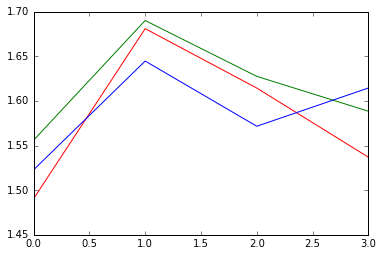

In [38]:
print(params_input)
print(params)
disp_results(param_comb, all_log_loss_ensemble_medi, all_log_loss_ensemble_mean,all_log_loss_validation)

{'scale_factor': 16, 'color_type_global': 1, 'interp': 'nearest'}
{'nb_dense': 60, 'dropout4': 0.6, 'optimizer': 'rmsprop', 'nb_filters3': 0, 'dropout1': 0.25, 'dropout2': 0.25, 'nb_filters1': 8, 'lr': 0.003, 'nb_conv': 3, 'nb_filters2': 10, 'dropout3': 0, 'weight_decay': 0.01, 'nb_pool': 2}


dropout4,0.4,0.4,0.4,0.4,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.6
weight_decay,0.003,0.003,0.01,0.01,0.003,0.003,0.01,0.01,0.003,0.003,0.01,0.01
scale_factor,12,16,12,16,12,16,12,16,12,16,12,16
log_loss_test_set_ensemble_median,1.48186,1.5549,1.59397,1.48509,1.46677,1.61673,1.6386,1.57034,1.5692,1.61886,1.54062,1.62882
log_loss_test_set_ensemble_mean,1.57596,1.60738,1.58068,1.50301,1.52891,1.60641,1.63135,1.60826,1.59522,1.62007,1.56997,1.68347
mean_log_loss_valid_set,1.58707,1.57547,1.48661,1.56228,1.54661,1.58593,1.58962,1.5948,1.48419,1.60788,1.50264,1.69062


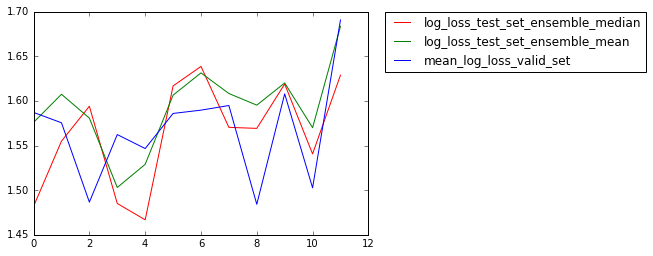

In [46]:
print(params_input)
print(params)
disp_results(param_comb, all_log_loss_ensemble_medi, all_log_loss_ensemble_mean,all_log_loss_validation)